In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf

In [5]:
df = pd.read_csv('../input/wind-power-forecasting/Turbine_Data.csv')

In [6]:
df.drop(columns = ['WTG','ControlBoxTemperature','Unnamed: 0'], inplace = True) #We drop WTG because every value was the same

In [7]:
columns = ['AmbientTemperatue' ,
           'BearingShaftTemperature',
           'Blade1PitchAngle', 
           'Blade2PitchAngle' ,
           'Blade3PitchAngle',
           'GearboxBearingTemperature',
           'GearboxOilTemperature',
           'GeneratorRPM','GeneratorWinding1Temperature','GeneratorWinding2Temperature',
           'HubTemperature',
           'MainBoxTemperature',
           'NacellePosition',
           'ReactivePower',
           'RotorRPM',
           'TurbineStatus', 
           'WindDirection',
           'WindSpeed']
for n in columns:
    df[n].fillna(df[n].median(),inplace = True)
for d in df:
    df.dropna(axis=0,how = 'any',inplace = True)

In [8]:
df.shape

(94750, 19)

In [9]:
target=['ActivePower']
X = df[columns]
Y= df[target]

In [10]:
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
144,-5.357727,23.148729,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,8.000000,-9.960830,10.098702,2.0,8.000000,2.279088
145,-5.822360,23.039754,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,300.428571,-9.628441,10.098702,2.0,300.428571,2.339343
146,-5.279409,22.948703,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,340.000000,-9.491235,10.098702,2.0,340.000000,2.455610
147,-4.648054,22.966851,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,345.000000,-9.856136,10.098702,2.0,345.000000,2.026754
148,-4.684632,22.936520,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,345.000000,-9.745593,10.098702,2.0,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,178.000000,3.533445
118220,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,178.000000,3.261231
118221,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,178.000000,3.331839
118222,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,190.000000,3.284468


In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3, random_state=1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [13]:
X_train, X_test, scaler = scale_data(x_train, x_test)
Y_train, Y_test, scaler = scale_data(y_train, y_test)

In [14]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [15]:
X_val, X_test, y_val, y_test = train_test_split(X_test, Y_test, test_size=0.50, random_state=42)

In [16]:
X_train.shape , Y_train.shape

((66325, 1, 18), (66325, 1))

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization()(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization()(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="linear")(x)
    return keras.Model(inputs, outputs)


In [20]:
input_shape = X_train.shape[1:]
n_classes =1
model = build_model(
    input_shape,
    head_size=8,
    num_heads=8,
    ff_dim=64,
    num_transformer_blocks=5,
    mlp_units=[512],
    mlp_dropout=0.4,
    dropout=0.1,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(),
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10)]

2022-11-15 22:41:15.313052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 22:41:15.433305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 22:41:15.434117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 22:41:15.435375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 18)]      0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 1, 18)        36          input_1[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 1, 18)        4818        layer_normalization[0][0]        
                                                                 layer_normalization[0][0]        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1, 18)        0           multi_head_attention[0][0]   

In [21]:
history=model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=callbacks,
)

Epoch 1/50


2022-11-15 22:41:18.652965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-15 22:41:22.673210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


104/104 [==============================] - 11s 18ms/step - loss: 0.0621 - val_loss: 0.0086
Epoch 2/50
104/104 [==============================] - 1s 12ms/step - loss: 0.0162 - val_loss: 0.0049
Epoch 3/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0101 - val_loss: 0.0025
Epoch 4/50
104/104 [==============================] - 1s 12ms/step - loss: 0.0075 - val_loss: 0.0026
Epoch 5/50
104/104 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 6/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 7/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 8/50
104/104 [==============================] - 1s 14ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 10/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0014

In [22]:
model.evaluate(X_train, Y_train, verbose=1)

2073/2073 [==============================] - 9s 4ms/step - loss: 9.0298e-04


0.0009029849315993488

In [23]:
model.evaluate(X_test, y_test, verbose=1)

445/445 [==============================] - 2s 5ms/step - loss: 8.2325e-04


0.0008232452673837543

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5
def print_metrics():
    print('Train   RMSE  value   : %.3f ' % root_mean_squared_error(Y_train, model.predict(X_train)))
    print('Train   MSE   value   : %.3f ' % mean_squared_error(Y_train, model.predict(X_train)))
    print('Train   R2    value   : %.3f ' % r2_score(Y_train,model.predict(X_train)))
    print('Train   MAPE  value   : %.3f ' % mean_absolute_percentage_error(Y_train, model.predict(X_train)))
    print('Train   RMLSE value   : %.3f ' % root_mean_squared_log_error(Y_train, model.predict(X_train)))
    print('Train   MAE   value   : %.3f ' % mean_absolute_error(Y_train, model.predict(X_train)))
    print('---------------------------------------------')
    print('Test    RMSE  value   : %.3f ' % root_mean_squared_error(y_test, model.predict(X_test)))
    print('Test    MSE   value   : %.3f ' % mean_squared_error(y_test, model.predict(X_test)))
    print('Test    R2    value   : %.3f ' % r2_score(y_test, model.predict(X_test)))
    print('Test    MAPE  value   : %.3f ' % mean_absolute_percentage_error(y_test, model.predict(X_test)))
    print('Test    RMLSE value   : %.3f ' % root_mean_squared_log_error(y_test, model.predict(X_test)))
    print('Test    MAE   value   : %.3f ' % mean_absolute_error(y_test, model.predict(X_test)))

In [25]:
print_metrics()

Train   RMSE  value   : 0.030 
Train   MSE   value   : 0.001 
Train   R2    value   : 0.992 
Train   MAPE  value   : 1735798972.020 
Train   RMLSE value   : 0.022 
Train   MAE   value   : 0.016 
---------------------------------------------
Test    RMSE  value   : 0.029 
Test    MSE   value   : 0.001 
Test    R2    value   : 0.993 
Test    MAPE  value   : 0.230 
Test    RMLSE value   : 0.021 
Test    MAE   value   : 0.016 


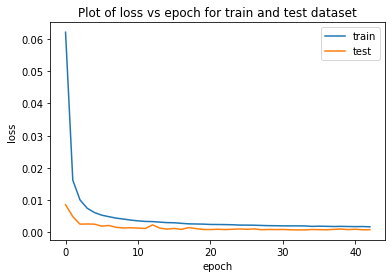

In [26]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()